<h1 style="text-align:center;"><strong>Modelo Predictivo en Python</strong></h1>



**1. Instalacion de librerias**

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install openpyxl
%pip install seaborn
%pip install scikit-learn
%pip install plotly
%pip install geopandas
%pip install nbformat==4.6.1
%pip install mplleaflet

**2. Importacion de librerias**

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


**3. Carga nacimientos por año**

In [4]:
data_2020 = pd.read_csv("nac2020.csv", encoding='latin1')
data_2021 = pd.read_csv("nac2021.csv", encoding='latin1')
data_2022 = pd.read_csv("nac2022.csv", encoding='latin1')

/tmp/ipykernel_685153/1232442687.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2022 = pd.read_csv("nac2022.csv", encoding='latin1')


**4. Juntar todos los nacimientos**


In [6]:
all_data = pd.concat([data_2020, data_2021, data_2022], ignore_index=True)


**5. Visualizar la cantidad de nacimientos por departamento a lo largo del tiempo**

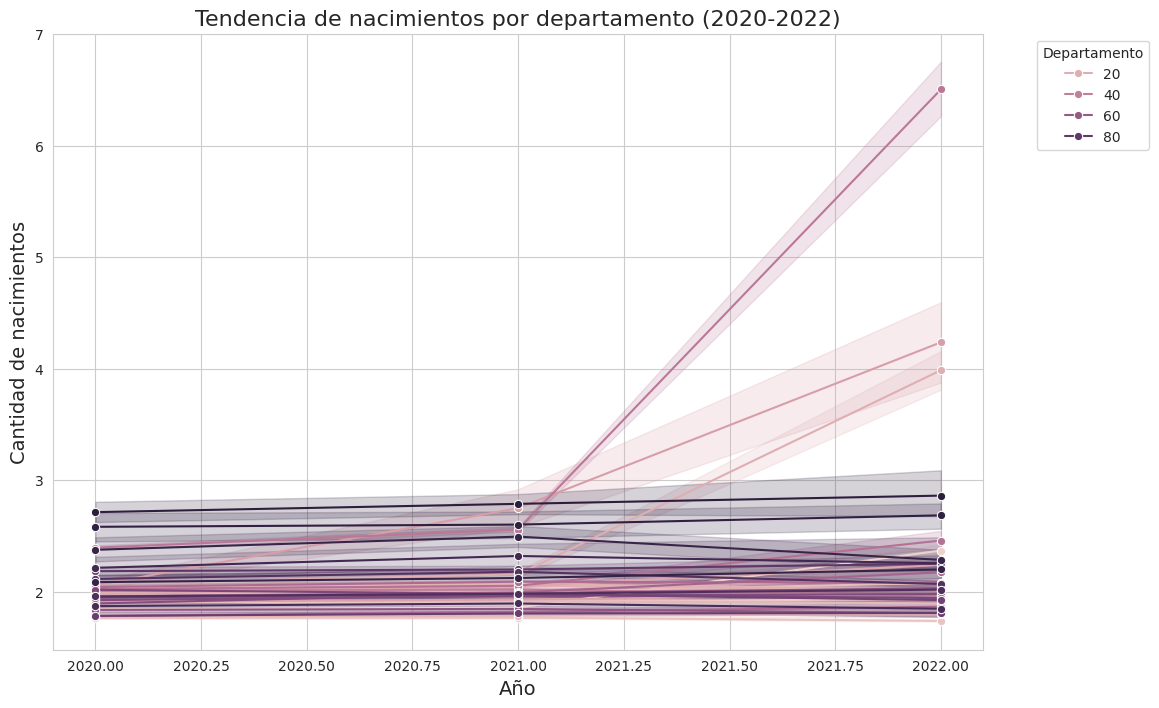

In [22]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

sns.lineplot(data=all_data, x='ANO', y='N_HIJOSV', hue='COD_DPTO', marker='o')

plt.title('Tendencia de nacimientos por departamento (2020-2022)', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Cantidad de nacimientos', fontsize=14)

plt.legend(title='Departamento', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**6. Entrenamiento de modelo**

<p># Dividir los datos en conjuntos de entrenamiento y prueba</p>

In [155]:
X_train, X_test, y_train, y_test = train_test_split(all_data[['COD_DPTO', 'ANO']], all_data['N_HIJOSV'], test_size=0.2, random_state=42)


**7. Entrenar un modelo de regresión aleatoria (Random Forest)**

In [247]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**8. Validación del modelo**


**Calcular el error cuadrático medio en el conjunto de prueba**

In [246]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio: {mse}")

Error cuadrático medio: 12.455104718448872


**9. Prediccion para el año 2024**

In [199]:
departamentos = all_data['COD_DPTO']
data_2024 = pd.DataFrame({'COD_DPTO': departamentos, 'ANO': 2024})
predicciones_2024 = model.predict(data_2024)

predicciones_df = pd.DataFrame({'COD_DPTO': departamentos, 'Predicciones_2024': predicciones_2024})
predicciones_por_departamento_2024 = predicciones_df.groupby('COD_DPTO')['Predicciones_2024'].sum().round()


**10. Antes del modelo predictivo**

In [200]:
all_data_2020_2024 = all_data[(all_data['ANO'] >= 2020) & (all_data['ANO'] <= 2024)]
nacimientos_2020_2024 = all_data_2020_2024.groupby('COD_DPTO')['N_HIJOSV'].sum()


**11. Gráfico de barras**

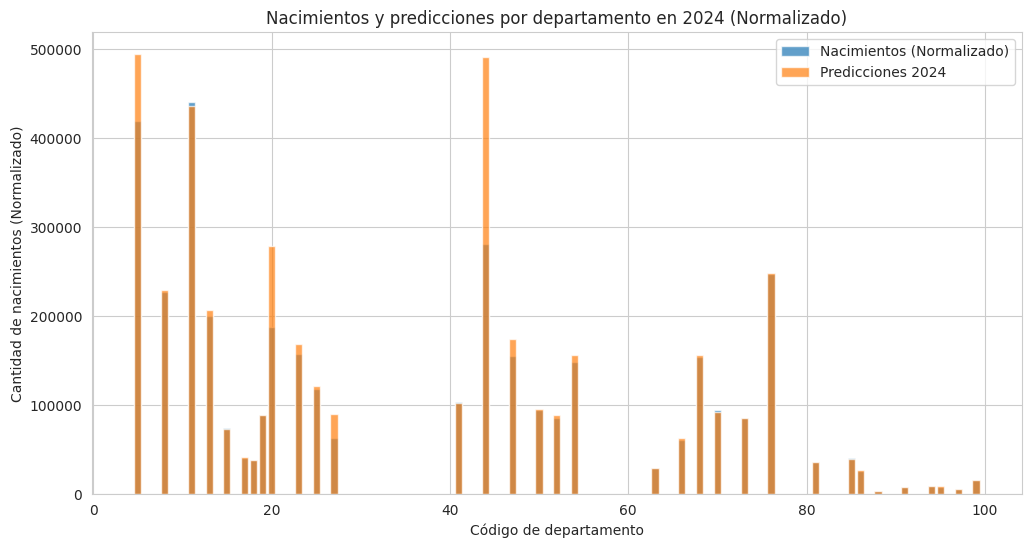

In [201]:
plt.figure(figsize=(12, 6))
plt.bar(nacimientos_2020_2024.index, nacimientos_2020_2024.values, label='Nacimientos (Normalizado)', alpha=0.7)
plt.bar(predicciones_por_departamento_2024.index, predicciones_por_departamento_2024.values, label='Predicciones 2024', alpha=0.7)
plt.title('Nacimientos y predicciones por departamento en 2024 (Normalizado)')
plt.xlabel('Código de departamento')
plt.ylabel('Cantidad de nacimientos (Normalizado)')
plt.legend()
plt.show()


**12. Gráfico de línea de tendencia temporal**

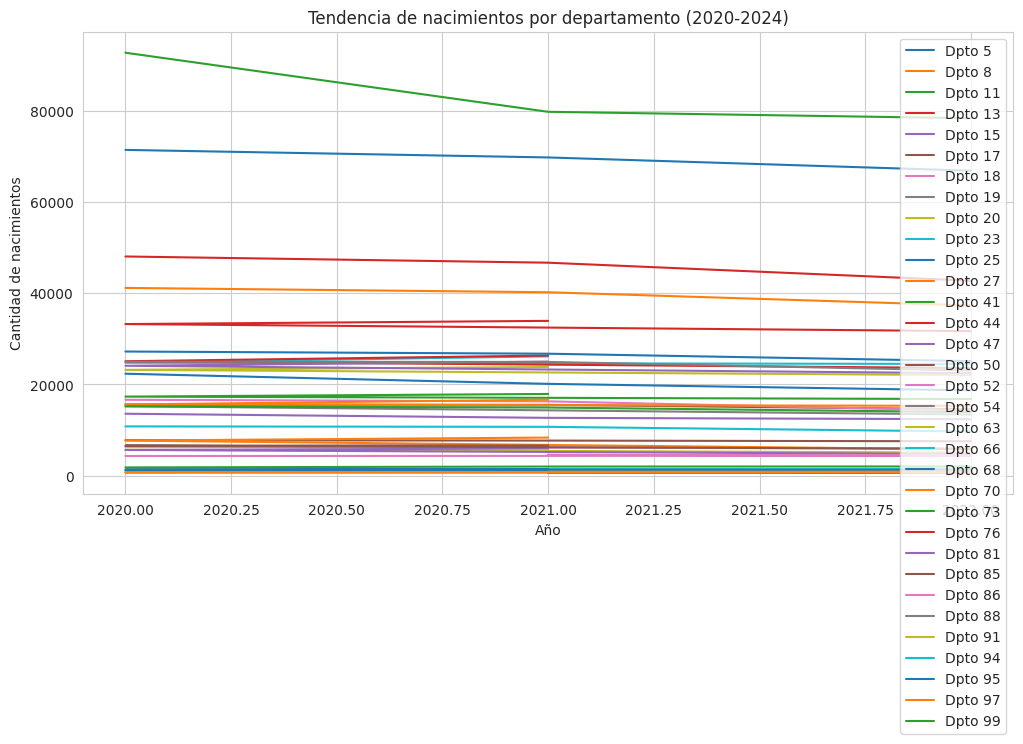

In [205]:
plt.figure(figsize=(12, 6))
for dpto in nacimientos_2020_2024.index:
    datos_dpto = all_data[(all_data['COD_DPTO'] == dpto) & (all_data['ANO'] >= 2020) & (all_data['ANO'] <= 2024)]
    plt.plot(datos_dpto['ANO'].value_counts().index, datos_dpto['ANO'].value_counts().values, label=f'Dpto {dpto}')
plt.title('Tendencia de nacimientos por departamento (2020-2024)')
plt.xlabel('Año')
plt.ylabel('Cantidad de nacimientos')
plt.legend()
plt.show()


**13. Mapa geoespacial**

In [230]:
geojson_path = 'colombia.geo.json'
data_geo = gpd.read_file(geojson_path)
predicciones_df_map = pd.DataFrame({'COD_DPTO': predicciones_por_departamento_2024.index, 'NACIMIENTOS': predicciones_por_departamento_2024.values})
predicciones_df_map['COD_DPTO'] = predicciones_df_map['COD_DPTO'].astype(str).str.zfill(2)


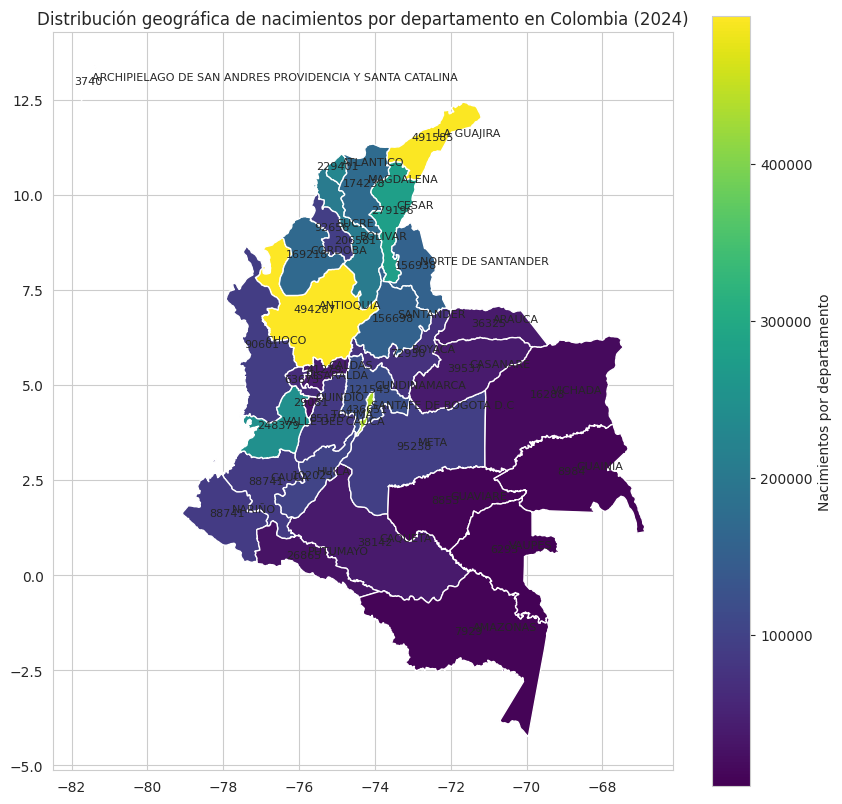

In [244]:
data_mapa = data_geo.merge(predicciones_df_map, how='left', left_on='DPTO', right_on='COD_DPTO')

fig, ax = plt.subplots(figsize=(10, 10))

# Plot
data_mapa.plot(ax=ax, column='NACIMIENTOS', cmap='viridis', legend=True,
               legend_kwds={'label': "Nacimientos por departamento"})

# Agregar etiquetas de valores
for idx, row in data_mapa.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['NACIMIENTOS']:.0f}", ha='center', fontsize=8)
    plt.annotate(text=row['NOMBRE_DPT'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 xytext=(3, 3), textcoords="offset points", fontsize=8)

# Agregar título
plt.title('Distribución geográfica de nacimientos por departamento en Colombia (2024)')

# Mostrar el mapa
plt.show()